In [1]:
%load_ext autoreload
%autoreload 2

In [22]:
from fastai2.vision.all import *
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from pathlib import Path
import torch
import torch.nn as nn
from torch.utils.data import DataLoader

from htools import *
from img_wang.data import MixupDS, load_img

In [23]:
cd_root()

Current directory: /Users/hmamin/img_wang


In [24]:
dir_u = Path('data/imagewang-160/unsup/')

In [25]:
ds = MixupDS(dir_u)
dl = DataLoader(ds, batch_size=2, shuffle=False)

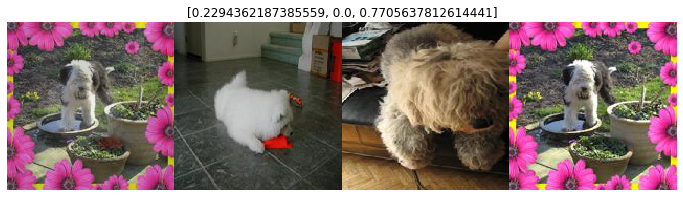

In [26]:
imgs, w = ds[100]
show_image(imgs, figsize=(12, 4), title=w.tolist())
plt.show()

In [27]:
*xb, yb = next(iter(dl))

In [39]:
class UnmixerModel(nn.Module):
    
    def __init__(self, n=3, c_in=3):
        super().__init__()
        self.n = n
#         self.encoder = Encoder()
        self.conv = nn.Conv2d(c_in, 6, kernel_size=3)
        
    def forward(self, xb):
        x_new, xs = xb.chunk(self.n+1, dim=-1)
        print(len(xs))
        return self.conv(x_new)
    
        x_new = 

In [40]:
net = UnmixerModel()

In [41]:
net(*xb).shape

3


torch.Size([2, 6, 158, 158])